# Final Project - Advanced Topics in Deep Learning, Part 1: Training Notebook


---
<br>

### Names and IDs:
Raz Diamond: 322281528
<br>
Ron Elyashar: 209350644
<br>
Liav Ermias: 211684956
<br>
Roeeii Itshayek: 212210751


# Introduction

### Import Libraries

In [ ]:
!pip install ipython-autotime
%load_ext autotime

import os
import random
import shutil

import gdown
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
from PIL import Image
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping, Callback, LambdaCallback
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, Dropout, BatchNormalization, Input, concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.03 s (started: 2025-03-20 20:06:24 +00:00)


### Download and Display the README File

In [ ]:
file_id = '132g8ydTBKMFADh5XMEwdpNs2G90IF_RE'
gdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', 'README.md', quiet=True)

with open('README.md', 'r') as file:
    explainer_content = file.read()

display(Markdown(explainer_content))

# **Advanced topics in Deep Learning Final Project**

By:\
**Raz Diamond (322281528)**, **Ron Elyashar (209350644)**,\
**Liav Ermias (211684956)** and **Roeeii Itshayek (212210751)**.

In this project, we were tasked with solving a **coloring** problem using methods we have learned over the semester. The
goal is to build a model capable of coloring images from
Kaggle's [20_UK_Garden_Birds](https://www.kaggle.com/datasets/davemahony/20-uk-garden-birds) dataset, which contains
**2,841 images** labeled across **20 classes**.

The assignment consists of two parts:

### **Pt. 1: Naive Image-to-Image Translation Deep Neural Network**

Three **naive DNN experiments** to solve the **coloring** problem.\
[🔗 Training Notebook (Part 1)](https://colab.research.google.com/drive/1tsFcOgRydmz39jILi01OOOYc0dqK1gfw?usp=sharing)\
[🔗 Testing Notebook (Part 1)](https://colab.research.google.com/drive/1uo53rHGtg1xbefcv1gLsO-dWiTX90TBj?usp=sharing)

### **Pt. 2: Image-to-Image Translation with Conditional Adversarial Networks**

Three **cGAN experiments** to solve the **coloring** problem. Inspired by a research paper from Berkeley.\
[🔗 Training Notebook (Part 2)](https://colab.research.google.com/drive/1HUJUY9YvVQKETTJ15odrARgyacliYpfl?usp=sharing)\
[🔗 Testing Notebook (Part 2)](https://colab.research.google.com/drive/1WfIW1RzE31Da0yKr0cYtFnKV_jaWskeV?usp=sharing)

We used the Python programming language, along with TensorFlow, Numpy, and Scikit-Learn. The notebooks were presented
using the Google Colab platform

## Structure of Colab Notebooks:

Each training notebook is divided into 4 sections:

- **Introduction** - Overview, imports, and dataset downloading.
- **Preprocessing** - Processing and preparing the dataset.
- **Experiments** - The three experiments we implemented.
- **Conclusions** - Key notes from this part.

Each testing notebook is a test environment, allowing users to upload an image and test it against our best model.

## Testing Our Implementation

To test our implementation of the assignments in each part:

1. Check the training notebook and the output of the cells.
2. Run the cells in the test notebook to try the best model by yourself.

### **Disclaimer**

Any files saved in the notebook's virtual machine (VM) will be deleted after the session ends.
To ensure persistence, we saved this file ("README.md") and the models (.keras files) in our Google Drive accounts.
These files are shared with anyone who has the links, allowing them to access and use them when running our notebooks.


time: 4.48 s (started: 2025-03-20 18:51:25 +00:00)


### Download the Dataset

Download the latest version of `20_UK_Garden_Birds`.<br>Check if `dataset` directory exists and create it if not.

In [ ]:
path = kagglehub.dataset_download("davemahony/20-uk-garden-birds")

dataset_path = "/content/dataset"

!if [ ! -d "$dataset_path" ]; then \
    mkdir /content/dataset && \
    cp -r ~/.cache/kagglehub/datasets/davemahony/20-uk-garden-birds/versions/7/* "$dataset_path";\
  else \
    echo "Dataset directory already exists. Skipping copy."; \
  fi

100%|██████████| 378M/378M [00:17<00:00, 22.3MB/s]

Extracting files...


time: 26.3 s (started: 2025-03-20 18:51:29 +00:00)


### Plot Random Example

Plot a random image from the dataset using Matplotlib

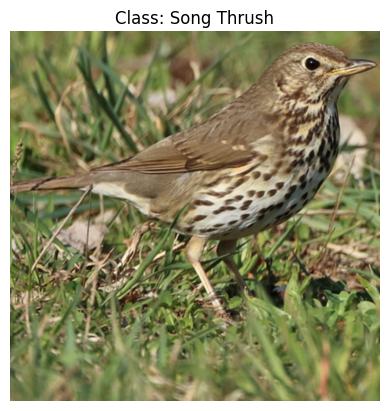

time: 310 ms (started: 2025-03-20 18:51:56 +00:00)


In [ ]:
sub_dir = "withBackground"
sub_dir_path = os.path.join(dataset_path, sub_dir)

class_dirs = os.listdir(sub_dir_path)
random_class = random.choice(class_dirs)

class_images = os.listdir(os.path.join(sub_dir_path, random_class))
random_image = random.choice(class_images)

image_path = os.path.join(sub_dir_path, random_class, random_image)
title = f"Class: {random_class.replace('_', ' ')}"

image = Image.open(image_path)
plt.imshow(image)
plt.axis("off")
plt.title(title)
plt.show()

# Preprocessing

### Split Dataset into Train, Validation and Test Sets

This code splits the dataset by copying images into a new `working` directory, dividing them into 70% for training, 10% for validation, and 20% for testing.

In [ ]:
train_ds_path = "/content/dataset/working/train/"
validation_ds_path = "/content/dataset/working/valid/"
test_ds_path = "/content/dataset/working/test/"
train_ratio = 0.7
validate_ratio = 0.1
test_ratio = 0.2

shutil.rmtree(train_ds_path, ignore_errors=True)
shutil.rmtree(validation_ds_path, ignore_errors=True)
shutil.rmtree(test_ds_path, ignore_errors=True)

os.makedirs(train_ds_path)
os.makedirs(validation_ds_path)
os.makedirs(test_ds_path)

for item in os.listdir(sub_dir_path):
    item_path = os.path.join(sub_dir_path, item)

    if os.path.isdir(item_path):
        os.makedirs(os.path.join(train_ds_path, item))
        os.makedirs(os.path.join(validation_ds_path, item))
        os.makedirs(os.path.join(test_ds_path, item))
        files = os.listdir(item_path)
        random.shuffle(files)
        num_images= len(files)
        train_images, validate_images, test_images = np.split(files, [int(num_images * train_ratio), int(num_images * (validate_ratio + train_ratio))])

        for image_path in train_images:
            src = os.path.join(item_path, image_path)
            dst = os.path.join(train_ds_path, item, image_path)
            shutil.copy(src, dst)

        for image_path in validate_images:
            src = os.path.join(item_path, image_path)
            dst = os.path.join(validation_ds_path, item, image_path)
            shutil.copy(src, dst)

        for image_path in test_images:
            src = os.path.join(item_path, image_path)
            dst = os.path.join(test_ds_path, item, image_path)
            shutil.copy(src, dst)

time: 469 ms (started: 2025-03-20 18:52:33 +00:00)


### Create Dataset

This code sets a batch size of 32 and image size of 128x128, defines data augmentation with 2 ops of random rotation and zoom, and builds datasets from paths. It loads, decodes, resizes, and augments JPEG images, normalizes them to [0, 1] (one grayscale, one color), then shuffles, batches, and prefetches. It creates train (augmented), validation, and test datasets, printing their sizes.

In [ ]:
batch_size = 32
image_size = (128, 128)

data_augmentation = layers.Pipeline([
    layers.RandomRotation(factor=0.3),
    layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3))
])

def build_dataset_from_path(path, augment=False):
    path_mask = f"{path}*/*.jpg"

    images_dataset = (
        tf.data.Dataset.list_files(path_mask)
        .map(lambda file_name: tf.io.read_file(file_name), num_parallel_calls=tf.data.AUTOTUNE)
        .map(lambda file_content: tf.image.decode_jpeg(file_content, channels=3), num_parallel_calls=tf.data.AUTOTUNE)
        .map(lambda img: tf.image.resize(img, image_size), num_parallel_calls=tf.data.AUTOTUNE)
    )

    preloaded_dataset = np.array([x for x in images_dataset])
    images_dataset = tf.data.Dataset.from_tensor_slices((preloaded_dataset))

    if augment:
        images_dataset = images_dataset.map(
            lambda img: data_augmentation(img), num_parallel_calls=tf.data.AUTOTUNE
        )

    normalized_dataset = images_dataset.map(
        lambda img: (tf.image.rgb_to_grayscale(img) / 255.0, img / 255.0), num_parallel_calls=tf.data.AUTOTUNE
    )


    print(f"Created Dataset with {len(images_dataset)} images.")
    return normalized_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Creating the Train Set:")
train_dataset = build_dataset_from_path(train_ds_path, augment=True)
print("\nCreating the Validation Set:")
validation_dataset = build_dataset_from_path(validation_ds_path)
print("\nCreating the Test Set:")
test_dataset = build_dataset_from_path(test_ds_path)

Creating the Train Set:
Created Dataset with 1986 images.

Creating the Validation Set:
Created Dataset with 269 images.

Creating the Test Set:
Created Dataset with 586 images.
time: 5.12 s (started: 2025-03-20 18:52:34 +00:00)


# Experiments

## Training Functions
The following functions are used to build, train, and evaluate the models.

### Class - Clear Session Callback
This class clears the GPU cache after each epoch, which is beneficial since each epoch differs due to data augmentations.

In [ ]:
class ClearSessionCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        tf.keras.backend.clear_session()

time: 406 µs (started: 2025-03-20 18:53:05 +00:00)


### Function - Plot Training Curves
Plots training & validation curves for Loss (MSE) and MAE.

In [ ]:
def plot_training_curves(history, title_suffix=''):
    plt.figure(figsize=(12,4))

    # Plot Loss (MSE)
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss During Training {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid()

    # Plot MAE
    plt.subplot(1,2,2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'MAE During Training {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

time: 720 µs (started: 2025-03-20 18:53:07 +00:00)


### Function - Visualize Predictions
Displays a comparison between original images, grayscale input, and model predictions.

In [ ]:
def visualize_predictions(model, dataset, title_suffix=''):
    X_test, y_test = next(iter(dataset))

    # Generate predictions
    preds = model.predict(X_test)
    num_images = 7

    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        # Original color image (Ground Truth)
        plt.subplot(3, num_images, i + 1)
        plt.imshow(y_test[i])
        plt.axis("off")
        plt.title("Original")

        # Grayscale input image
        plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(X_test[i, :, :, 0], cmap="gray")
        plt.axis("off")
        plt.title("Grayscale")

        # Predicted color image
        plt.subplot(3, num_images, 2 * num_images + i + 1)
        plt.imshow(preds[i])
        plt.axis("off")
        plt.title("Predicted")

    plt.suptitle(f"Model Predictions {title_suffix}", fontsize=16)
    plt.tight_layout()
    plt.show()

time: 790 µs (started: 2025-03-20 18:53:08 +00:00)


## Experiment 1 - Image-to-Image MLP

In this experiment we will try to solve the problem in the most naive way, simple Fully Connected Neural Netwrok

### Architecture

The model we built is an MLP (Multilayer Perceptron), i.e., a multi-layer neural network. The model receives a grayscale image, transforms it into a one-dimensional vector (Flatten), and after processing in several Fully Connected layers, recreates a color image.

The **ReLU (Rectified Linear Unit)** function allows the network to learn nonlinear transformations, which helps in:

- Solving the **Vanishing Gradient Problem**.
- Enabling **more stable** and **faster learning** compared to Sigmoid or Tanh.
- Improving the **overall ability** of the model.

Pixels in an image are values between 0 and 1, so **Sigmoid** is the optimal choice. It ensures that each pixel is in the range **[0,1]**, as in a normal image.

If we were to use **ReLU**, we could get values greater than 1, which is not correct.

If we had used **Tanh**, the pixels would have been in the range **[-1,1]**, which would have required another transformation.


### Hyperparameters

**Optimizer: Why Adam?**

Adam (Adaptive Moment Estimation) is an adaptive optimizer that adjusts the learning rate for each parameter dynamically.

**Why Adam?**
- Combines **Momentum** and **Adaptive Learning Rate** → Faster convergence.
- **More stable** than SGD, especially in deep models.
- Handles **unstable gradients** well, which is important for colorization.

---

**Learning Rate**  
- Adam’s default **learning rate = 0.001**.

---

**Epochs**  
- The model runs for up to **200 epochs**, but **EarlyStopping** prevents unnecessary training.  
- More epochs allow better learning, but **risk overfitting**.

**Why 200 instead of 50?**  
- **Fully Connected networks** have many parameters → Require longer training.  
- **EarlyStopping** ensures training stops when no improvement is detected.

**EarlyStopping Settings:**  
- `monitor='val_loss'` → Tracks validation loss (MSE).  
- `patience=10` → Stops training if no improvement for 10 consecutive epochs.  
- `restore_best_weights=True` → Restores best-performing weights at the end.

---

**Regularization**  
We also use **Batch Normalization** and **Dropout** to improve generalization and prevent overfitting.


### Build the Model

In [ ]:
# Define MLP model
model_mlp = Sequential([
    Flatten(input_shape=(128, 128, 1)),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2048, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128*128*3, activation='sigmoid'),
    Reshape((128,128,3))
])

# Compile and train model
model_mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_mlp.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2048)                │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 49152)               │     100,712,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 128, 128, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,740,416 (426.26 MB)

 Trainable params: 111,733,248 (426.23 MB)

 Non-trainable params: 7,168 (28.00 KB)

time: 76.9 ms (started: 2025-03-20 19:00:20 +00:00)


### Train the Model

Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.0545 - mae: 0.1838 - val_loss: 0.2280 - val_mae: 0.4212
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0396 - mae: 0.1541 - val_loss: 0.1126 - val_mae: 0.2748
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0370 - mae: 0.1480 - val_loss: 0.0520 - val_mae: 0.1741
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0373 - mae: 0.1479 - val_loss: 0.0385 - val_mae: 0.1488
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0358 - mae: 0.1448 - val_loss: 0.0442 - val_mae: 0.1626
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0360 - mae: 0.1453 - val_loss: 0.0436 - val_mae: 0.1596
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0355 - mae: 0.1442 - val_loss: 0.0400 - val_mae: 0.1530
Epoch 8/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0356 - mae: 0.1446 - val_loss: 0.0385 - val_mae: 0.1500
Epoch 9/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - l

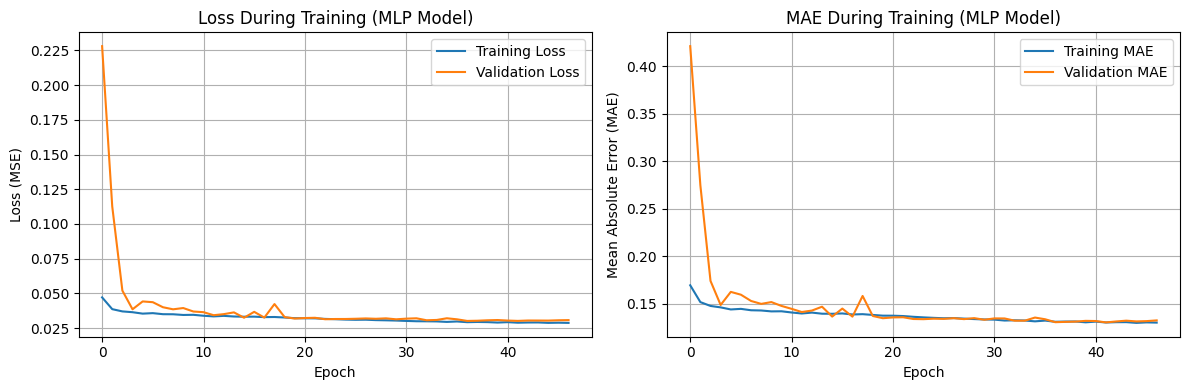

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


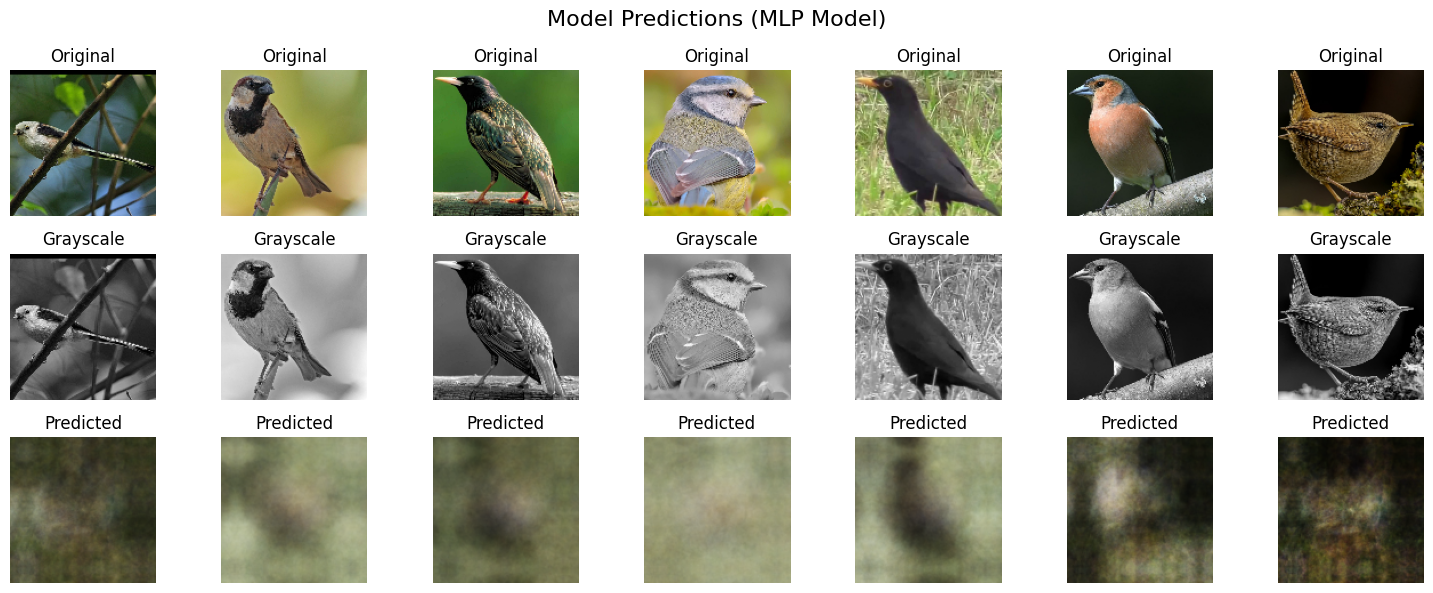

time: 1min 51s (started: 2025-03-20 19:00:23 +00:00)


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
clear_session_callback_1 = ClearSessionCallback()

history_mlp = model_mlp.fit(
    train_dataset,
    epochs=200,
    validation_data=validation_dataset,
    callbacks=[early_stop, clear_session_callback_1]
)

# Save model
model_mlp.save('mlp_colorization.keras')
print("MLP model saved at:", os.path.abspath('mlp_colorization.keras'))

# Evaluate model
plot_training_curves(history_mlp, title_suffix='(MLP Model)')
visualize_predictions(model_mlp, validation_dataset, title_suffix='(MLP Model)')

## Experiment 2 - Image-to-Image CNN

In this experiment we will try building a convolutional netwrok that solves the problem. because our output is an image, our network is Fully Convolutional (No dense layers).

### Architecture

Our CNN model consists of three main stages:

- The **Contracting Path (Encoder)** learns the image structure and reduces its dimensions.
- The **Bottleneck Layer** processes the information and serves as a transition between encoding and decoding.
- The **Expanding Path (Decoder)** reconstructs the color image.

The model uses **Conv2D layers** with a kernel size of (3, 3) to extract spatial features from the image. ReLU activation is applied in all Conv2D layers to improve stability and prevent the vanishing gradients problem.

The final Conv2D layer uses `strides=2`, which functions similarly to a "Pooling" layer, reducing the resolution to focus on important features.

To enlarge the image back to its original size, the model uses **Conv2DTranspose** for upsampling. After that, **Conv2D** layers are used to improve accuracy and restore details that were lost during compression.

The output layer consists of **3 channels (RGB)**, achieved using **Conv2D(3, (1,1))**. **Sigmoid activation** ensures that the output values remain within the range of [0,1], corresponding to pixel values.


### Build the Model

In [ ]:
model_cnn = Sequential([
    Input(shape=(128, 128, 1)),

    # Contracting path (Encoder)
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), strides=2, padding='same'),
    BatchNormalization(),

    # Bottleneck layer (middle)
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),

    # Expanding path (Decoder)
    Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),

    #Output
    Conv2D(3, (1, 1), activation='sigmoid', padding='same')
])

# Compile and train model
model_cnn.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 128, 128, 3)         │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 741,891 (2.83 MB)

 Trainable params: 740,355 (2.82 MB)

 Non-trainable params: 1,536 (6.00 KB)

time: 120 ms (started: 2025-03-20 19:02:38 +00:00)


### Train the Model

Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - loss: 0.0282 - mae: 0.1144 - val_loss: 0.0548 - val_mae: 0.1900
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0100 - mae: 0.0717 - val_loss: 0.0525 - val_mae: 0.1856
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0081 - mae: 0.0629 - val_loss: 0.0497 - val_mae: 0.1822
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0079 - mae: 0.0620 - val_loss: 0.0440 - val_mae: 0.1716
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0077 - mae: 0.0609 - val_loss: 0.0423 - val_mae: 0.1690
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0077 - mae: 0.0613 - val_loss: 0.0344 - val_mae: 0.1510
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0074 - mae: 0.0602 - val_loss: 0.0250 - val_mae: 0.1286
Epoch 8/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0071 - mae: 0.0580 - val_loss: 0.0216 - val_mae: 0.1189
Epoch 9/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - 

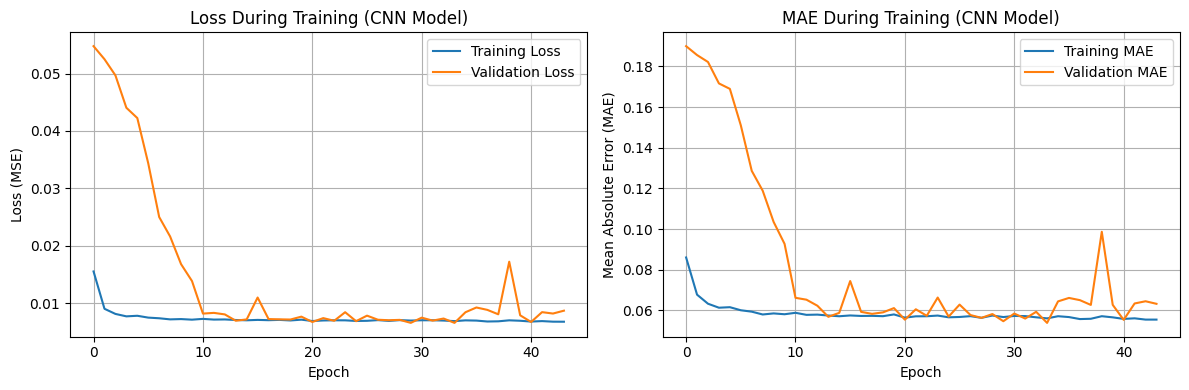

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


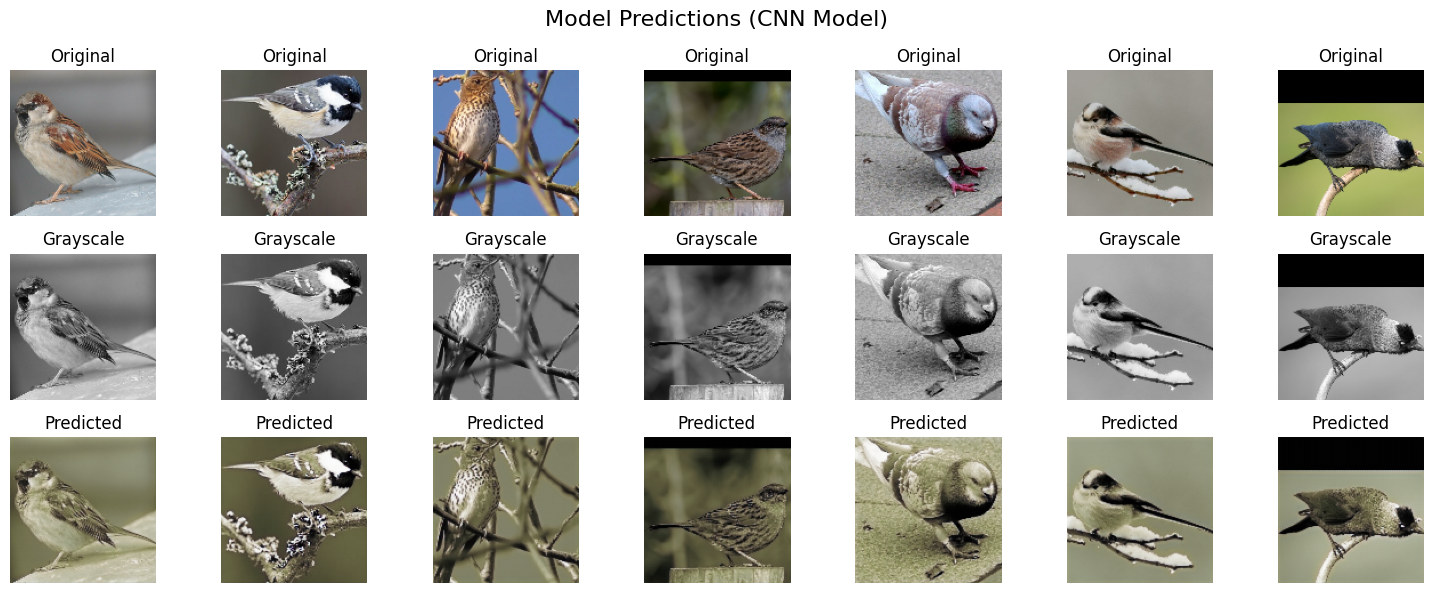

time: 3min 16s (started: 2025-03-20 19:02:41 +00:00)


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
clear_session_callback_2 = ClearSessionCallback()

history_cnn = model_cnn.fit(
    train_dataset,
    epochs=200,
    validation_data=validation_dataset,
    callbacks=[early_stop, clear_session_callback_2]
)

# Save model
model_cnn.save('cnn_colorization.keras')
print("CNN model saved at:", os.path.abspath('cnn_colorization.keras'))

# Evaluate model
plot_training_curves(history_cnn, title_suffix='(CNN Model)')
visualize_predictions(model_cnn, validation_dataset, title_suffix='(CNN Model)')

## Experiment 3 - Image-to-Image U-Net

in this experiment we will use U-Net

### Architecture

U-Net is a **convolutional neural network (CNN)** designed specifically for image-to-image tasks. It consists of two main parts:

- The **Contracting Path (Encoder)** extracts features and creates a compact representation of the image (downsampling).
- The **Expanding Path (Decoder)** recovers information and restores the image to its original size (upsampling).

Each stage of the model includes **Conv2D layers, ReLU activation, and Batch Normalization**. **Stride-2 Convolutions** are used in the Encoder to reduce image dimensions instead of MaxPooling. **Conv2DTranspose layers** are responsible for upsampling in the Decoder.

The model uses the **ReLU (Rectified Linear Unit)** activation function in all **Conv2D layers** to prevent **vanishing gradients** and speed up learning by keeping only positive values (**max(0, x)**). The final output layer uses **Sigmoid** activation to ensure the pixel values stay in the range of **[0,1]**, producing a valid RGB image.

In the **Encoder (Downsampling)** part, the architecture begins with **Conv2D(64, 3, activation="relu", padding="same")** to learn initial features. **BatchNormalization()** is applied to normalize the data and accelerate learning, while **Conv2D(128, 3, activation="relu")** increases the depth of the filters to capture more complex features. **Stride-2 Convolutions** reduce the image dimensions by **50% per step**, replacing MaxPooling.

In the **Decoder (Upsampling)**, **Conv2DTranspose** layers are used to increase the image dimensions back to their original size. **Skip Connections** from the Encoder to the Decoder preserve important spatial details that might be lost during the upsampling process.

U-Net is particularly powerful for image-to-image translation tasks due to its ability to preserve spatial information using **Skip Connections**, and it achieves higher accuracy compared to standard CNN architectures. By ensuring the model doesn't just "guess" colors but also maintains the crucial spatial relationships, U-Net offers a significant advantage in tasks like image colorization.


### Build the Model

In [ ]:
def build_unet(input_shape=(128,128,1)):
    inputs = Input(shape=input_shape)

    # Contracting path (Encoder)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    pool1 = Conv2D(64, 3, strides=2, padding='same')(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = Conv2D(128, 3, strides=2, padding='same')(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)

    # Expanding path (Decoder)
    up1 = Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(conv3)
    up1 = concatenate([up1, conv2])  # Skip connection from conv2
    up1 = Conv2D(128, 3, activation='relu', padding='same')(up1)

    up2 = Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(up1)
    up2 = concatenate([up2, conv1])  # Skip connection from conv1
    up2 = Conv2D(64, 3, activation='relu', padding='same')(up2)

    # Output layer
    output = Conv2D(3, 1, activation='sigmoid', padding='same')(up2)

    return Model(inputs, output)

model_unet = build_unet()
model_unet.compile(optimizer='adam', loss='mse', metrics=['mae'])


time: 107 ms (started: 2025-03-20 19:06:42 +00:00)


### Train the Model

Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0066 - mae: 0.0541 - val_loss: 0.0067 - val_mae: 0.0550
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0064 - mae: 0.0526 - val_loss: 0.0100 - val_mae: 0.0737
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0068 - mae: 0.0532 - val_loss: 0.0065 - val_mae: 0.0525
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0066 - mae: 0.0527 - val_loss: 0.0070 - val_mae: 0.0576
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0065 - mae: 0.0535 - val_loss: 0.0068 - val_mae: 0.0567
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0064 - mae: 0.0527 - val_loss: 0.0065 - val_mae: 0.0529
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0063 - mae: 0.0514 - val_loss: 0.0068 - val_mae: 0.0558
Epoch 8/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0064 - mae: 0.0519 - val_loss: 0.0072 - val_mae: 0.0586
Epoch 9/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - lo

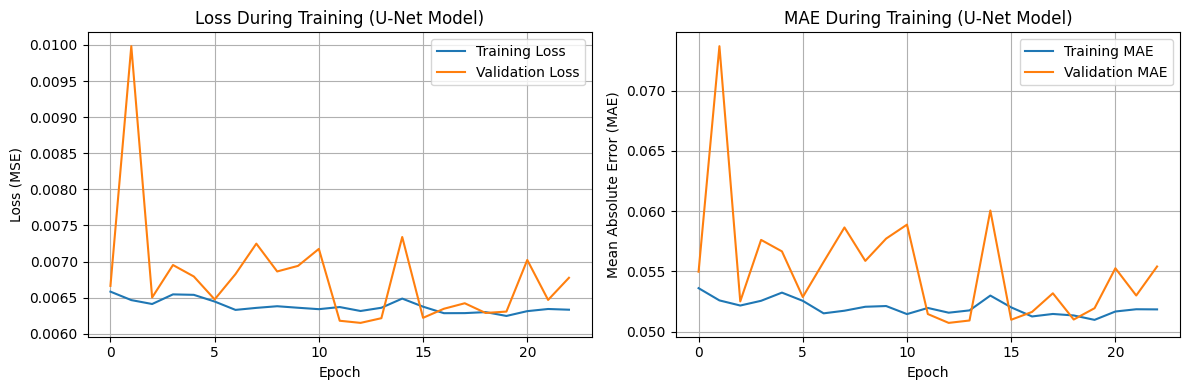

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


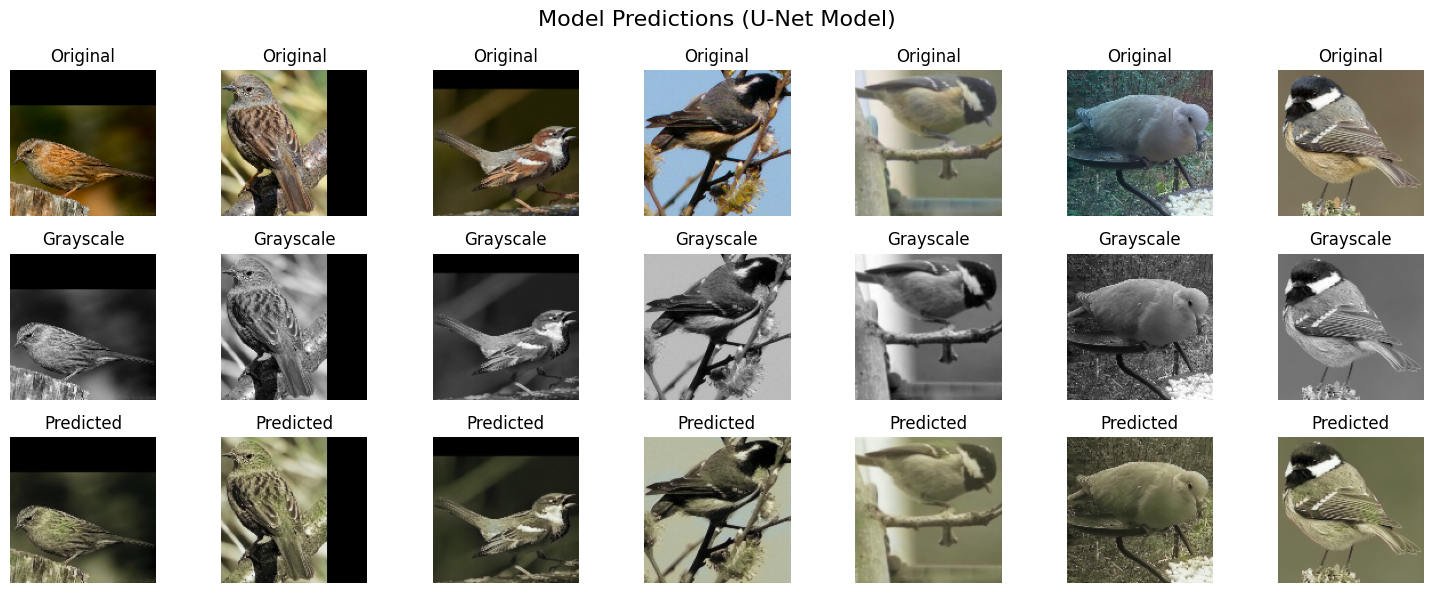

time: 1min 12s (started: 2025-03-20 19:11:45 +00:00)


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
clear_session_callback_3 = ClearSessionCallback()

history_unet = model_unet.fit(
    train_dataset,
    epochs=200,
    validation_data=validation_dataset,
    callbacks=[early_stop, clear_session_callback_3]
)

# Save model
model_unet.save('unet_colorization.keras')
print("UNet model saved at:", os.path.abspath('unet_colorization.keras'))

# Evaluate model
plot_training_curves(history_unet, title_suffix='(U-Net Model)')
visualize_predictions(model_unet, validation_dataset, title_suffix='(U-Net Model)')


# Conclusions

### Evaluate the Best Model on the Test Set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


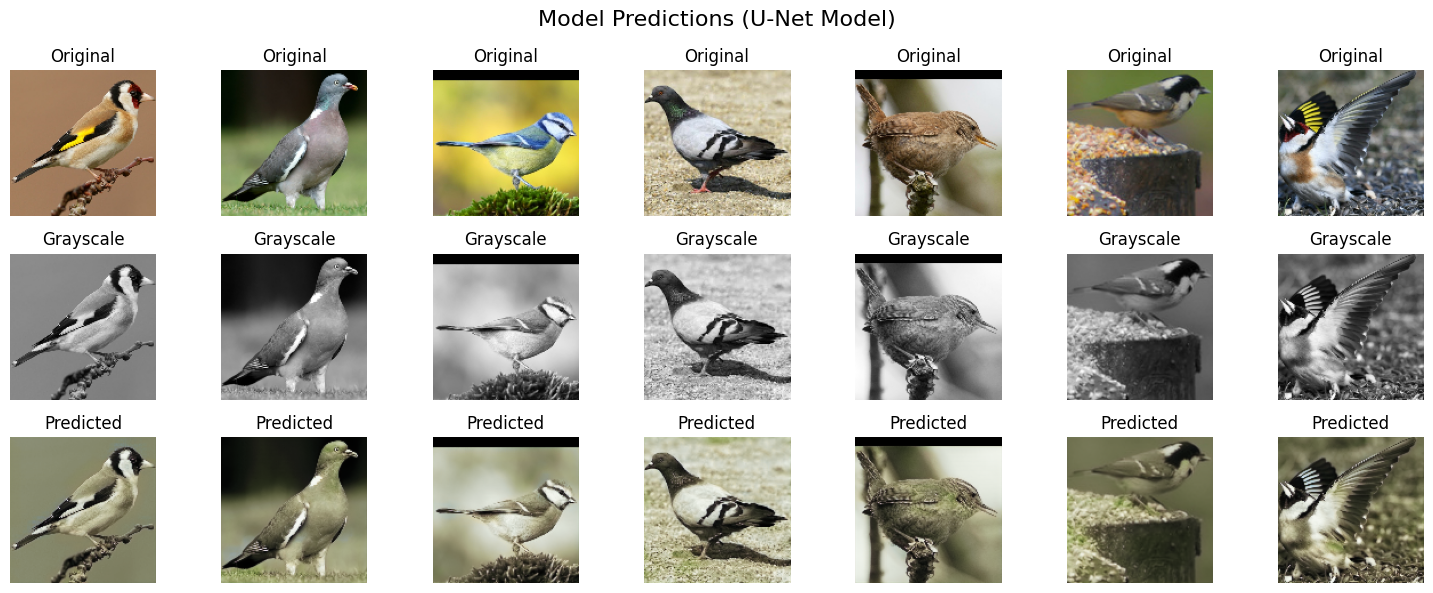

time: 1.07 s (started: 2025-03-20 19:14:48 +00:00)


In [ ]:
visualize_predictions(model_unet, test_dataset, title_suffix='(U-Net Model)')

### Final Thoughts

### Summary of Experimental Results  

We tested three models for Image Colorization:  

- **MLP (Multilayer Perceptron)**  
- **CNN (Convolutional Neural Network)**  
- **U-Net (CNN with Skip Connections)**  

The goal was to determine the best model based on **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)** on the validation set.  

---  

### **1. MLP Results**  
- MSE and MAE decrease, but validation loss plateaus quickly.  
- **Final MAE: 0.1307** → High average pixel error.  
- Struggles with color reproduction due to lack of spatial information.  

---  

### **2. CNN Results**  
- Sharp MSE and MAE drop in early epochs.  
- **Better color reproduction** than MLP.  
- Lower validation loss → **Better generalization.**  
- Captures spatial features but has room for improvement.  

---  

### **3. U-Net Results**  
- **Similar to CNN but more stable.**  
- **Skip Connections** help smoother color reproduction.  
- **Lowest validation loss**, indicating strong generalization.  

---  

### **Performance Comparison (Validation Set)**  

**MSE:**  
- **U-Net:** 0.0062  
- **CNN:** 0.0066  
- **MLP:** 0.0301  

**MAE:**  
- **U-Net:** 0.0507  
- **CNN:** 0.0538  
- **MLP:** 0.1307  

Insight: CNN and U-Net perform similarly, but U-Net is more stable and preserves image structure better.  